**Notebook for the classification of skin lesions**

In this notebook I present to you how a deep learning pipeline to classifiy skin lesions can be created using the framework AUCMEDI. The dataset used in this notebook is the ISIC 2019 dataset (available on Kaggle https://www.kaggle.com/datasets/andrewmvd/isic-2019). This dataset contains 25,331 images from nine classes. (Melanoma (MEL), Melanocytic nevus (NV), Basal cell carcinoma (BCC), Actinic keratosis (AK), Benign keratosis (BKL), Dermatofibroma (DF), Vascular lesion (VASC), Squamous cell carcinoma (SCC), Unknown (UNK))

**Install AUCMEDI**

First of all we have to install AUCMEDI

In [1]:
#install aucmedi
!pip install aucmedi

Defaulting to user installation because normal site-packages is not writeable
  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


**Imports**

Next we make the necessary imports

In [19]:
# AUCMEDI library
from aucmedi import *
TF_ENABLE_ONEDNN_OPTS=0

**Change csv-file**

First of all we take a closer look at the csv file with the GroundTruth Data and we load the csv file in a dataframe. The variable `csv_file` stores the path to the csv file and can be changed if the path on your computer is different.

In [20]:
import pandas as pd
#variable for the csv file
csv_file = "data/ISIC/ISIC_2019_Training_GroundTruth.csv"

In [21]:
data = pd.read_csv(csv_file)

The unkown column is removed, this class does not contain any sample an leads to problems later. The changed dataframe is saved as the csv file.

In [5]:
data.drop('UNK', axis=1, inplace=True)
data.to_csv(csv_file, index=False)

**Plot the sizes of the image**

We define a variable for the image directory `image_directory`. If the path is different in your notebook, you can change it.

In [22]:
import os
from PIL import Image

#set the variable for the image directory
image_directory = "data/ISIC/ISIC_2019_Training_Input/ISIC_2019_Training_Input/"

Next we take a closer look at the sizes of the images. But first we recognise that in the file for the images exist a txt. file called ATTRIBUTION.txt. This file has to be removed.

In [ ]:
#remove the ATTRIBUTION.txt file that is no image file
os.remove(image_directory + "ATTRIBUTION.txt") 

Now we create two lists for the width and the heights of the images to visualize them.

In [8]:
#get the directory
directory = os.fsencode(image_directory)

#lists to store the height and width of each image
list_height = []
list_width = []

#iterate through all files in the directory
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if (filename.endswith(".jpg")):
        with Image.open(image_directory + filename) as img:
            #append the height and width of the image to the list
            width, height = img.size
            list_height.append(height)
            list_width.append(width)


Text(0, 0.5, 'images height')

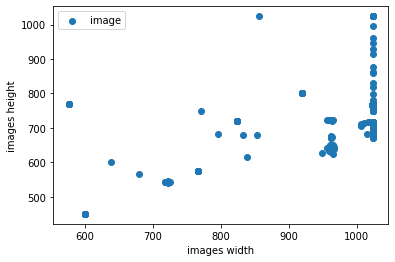

In [11]:
import matplotlib.pyplot as plt
#create the plot for the heights and widths of each image
plt.scatter(list_width, list_height, label='image')
plt.legend()
plt.show
plt.xlabel('images width')
plt.ylabel('images height')

We can see that the majority of the images have a width of about 1000 pixels, the height is normally between 700 and 1000 pixels. 

**Obtaining general dataset information**

AUCMEDI is based on three pillars (https://github.com/frankkramer-lab/aucmedi/blob/master/README.md): 
* Pillar 1: `input_interface()` for obtaining general dataset 
information
* Pillar 2: `NeuralNetwork()` for the deep learning model
* Pillar 3: `DataGenerator()` for a powerful interface to load any images/volumes into your model

We start with the first pillar: the `input_interface`. The csv file is one hot encoded, that means that each class has its column and for each image it is encoded in 0/1 if it belongs to the class.

In [23]:
# Peak data information via the first pillar of AUCMEDI
ds = input_interface(interface="csv",                       # Interface type
                     path_imagedir=image_directory,
                     path_data=csv_file,
                     ohe=True, col_sample="image", col_class=['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC'])
(samples, class_ohe, nclasses, class_names, image_format) = ds

One feature of AUCMEDI is that a function to analyse the dataset is provided. Here a barplot for the class distribution is created and saved in the directoy of `out_path`. If wished a heatmap plot can be generated, too, but in this case the heatmap does not contain additional value. 

/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 10 x 9 in image.
/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: data/evaluation/plot.dataset.barplot.png


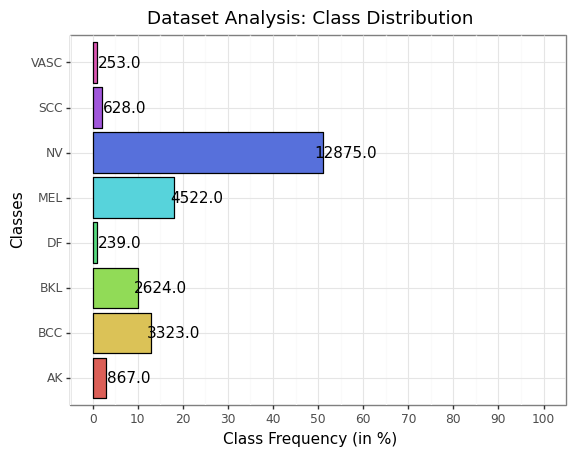

,class,class_freq,class_perc
0,MEL,4522.0,18.0
1,NV,12875.0,51.0
2,BCC,3323.0,13.0
3,AK,867.0,3.0
4,BKL,2624.0,10.0
5,DF,239.0,1.0
6,VASC,253.0,1.0
7,SCC,628.0,2.0


In [24]:
from aucmedi.evaluation.dataset import evaluate_dataset

# Pass information to the evaluation function
evaluate_dataset(samples, class_ohe, out_path="./data/evaluation", class_names=class_names, show=True, plot_barplot=True)

In general the distribution of the classes is very unbalanced: the NV class contains about the half of the samples whereas the DF and VASC class contain only 1 % of the samples. This is important later for training and and the evaluation of test sets.

**The model**

The next section describes the second pillar of aucmedi: the `NeuralNetwork()` for the deep learning model

As we have seen above the classes are unbalanced but we can solve this problem by using class weights. The class weights can be computed with a function from AUCMEDI. The return value `cw_loss` is a list of the class weight which can be feeded to a loss function and `cw_fit` is a dictionary with the class weight which can be feeded to train() or keras.model.fit().

In [25]:
from aucmedi.utils.class_weights import compute_class_weights

# Compute class weights
cw_loss, cw_fit = compute_class_weights(class_ohe)

Now a model is created, in this case the architecture chosen is VGG16. A list of all available 2D architectures can be found at https://frankkramer-lab.github.io/aucmedi/reference/neural_network/architectures/image/#aucmedi.neural_network.architectures.image. Here the class weights are used for the loss function, here the `categorial_focal_loss` function.

In [27]:
from aucmedi.neural_network.loss_functions import categorical_focal_loss
from aucmedi.neural_network.model import NeuralNetwork

# Pillar #2: Initialize a model with ImageNet weights
model = NeuralNetwork(n_labels=nclasses, channels=3, 
                        loss=categorical_focal_loss(cw_loss),
                        architecture="2D.VGG16",
                        pretrained_weights=True)

2022-08-30 15:47:58.900885: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-30 15:47:59.738379: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22844 MB memory:  -> device: 0, name: NVIDIA TITAN RTX, pci bus id: 0000:40:00.0, compute capability: 7.5


For training and evaluating the model we need three sets: the `training_set` to train the model, the `validation_set` is used to tune the hyperparameters of the model and the `test_set` is used to evaluate the model. Here we the training_set contains 75 % of the samples, the validation_set contrains 20 % of the samples and 5 % are the test_set.

In [28]:
from aucmedi.sampling.split import sampling_split

split_ratio = [0.75, 0.20, 0.05]
ds = sampling_split(samples, labels=class_ohe, sampling=split_ratio)

In [29]:
train_set = ds[0]
validation_set = ds[1]
test_set = ds[2]

The sets can be stored and reused later, in this case the `test_set` is saved.

In [30]:
import pickle
import numpy as np

In [31]:
with open("./data/model_EfficientNetB4/test.txt", "wb") as fp:
    pickle.dump(test_set[0], fp)
    
with open('test.npy', 'wb') as f:
    np.save("./data/model_EfficientNetB4/test.npy", test_set[1])

In [32]:
samples = []
with open("./data/model_EfficientNetB4/test.txt", "rb") as fp:
    samples = pickle.load(fp)
    
with open("./data/model_EfficientNetB4/test.npy", 'rb') as f:
    labels = np.load(f)
    
test_set = [samples, labels]

In the next section we define callback functions that will help us to optimize our training. `ReduceLROnPlateau` and `EarlyStopping` both monitor the `val_loss` metric and if the `val_loss` has not decreased after five epochs (the `patience`) `ReduceLROnPlateau` reduces the learning rate and `EarlyStopping` stops the training.

In [33]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
    
# Define callback reduce learning rate on plateau
cb_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, 
                          mode='min', min_delta=0.0001, cooldown=1,    
                          min_lr=0.00001)
# Define callback early stopping
cb_es = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, 
                      mode='min')

**The DataGenerator**

Two DataGenerators are created (one for training and one for validation) that are used for training the model later.

In [34]:
# Pillar #3: Initialize training Data Generator
train_gen = DataGenerator(samples=train_set[0],
                          path_imagedir=image_directory,
                          labels=train_set[1],
                          image_format=image_format,
                          resize=model.meta_input,
                          standardize_mode=model.meta_standardize)

validation_gen = DataGenerator(samples=validation_set[0],
                              path_imagedir=image_directory,
                              labels=validation_set[1],
                              image_format=image_format,
                              resize=model.meta_input,
                              standardize_mode=model.meta_standardize)

Finally we can train our model. The number of epochs is set to 1000 but likely we will need less epochs because of the callback-functions.

In [35]:
# Run model training with Transfer Learning
history = model.train(train_gen, validation_gen, epochs=1000, callbacks=[cb_lr, cb_es], transfer_learning=True)

Epoch 1/10


2022-08-30 15:48:21.394440: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-08-30 15:48:21.995345: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


594/594 [==============================] - 259s 430ms/step - loss: 3.2870 - categorical_accuracy: 0.2753 - val_loss: 1.6554 - val_categorical_accuracy: 0.3660 - lr: 1.0000e-04
Epoch 2/10
594/594 [==============================] - 207s 348ms/step - loss: 2.1791 - categorical_accuracy: 0.3722 - val_loss: 1.3775 - val_categorical_accuracy: 0.5290 - lr: 1.0000e-04
Epoch 3/10
594/594 [==============================] - 203s 341ms/step - loss: 1.8422 - categorical_accuracy: 0.4028 - val_loss: 1.1960 - val_categorical_accuracy: 0.5067 - lr: 1.0000e-04
Epoch 4/10
594/594 [==============================] - 207s 349ms/step - loss: 1.5865 - categorical_accuracy: 0.4263 - val_loss: 1.1895 - val_categorical_accuracy: 0.4862 - lr: 1.0000e-04
Epoch 5/10
594/594 [==============================] - 209s 352ms/step - loss: 1.4604 - categorical_accuracy: 0.4365 - val_loss: 1.1320 - val_categorical_accuracy: 0.5249 - lr: 1.0000e-04
Epoch 6/10
594/594 [==============================] - 207s 348ms/step - loss

The trained model can now be stored and loaded later to reuse it.

In [36]:
# Save the model
model.dump('data/model_VGG16/model')

INFO:tensorflow:Assets written to: data/model_VGG16/model/assets


INFO:tensorflow:Assets written to: data/model_VGG16/model/assets


In [37]:
model.load('data/model_VGG16/model')

The training can now be evaluated and the plot is stored at the directoy of `out_path`.

In [38]:
from aucmedi.evaluation.fitting import evaluate_fitting

# Pass history dict to evaluation function
evaluate_fitting(history, out_path="./data/model_VGG16/")

/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: data/model_VGG16/plot.fitting_course.png


Now we want to see how the model performs on other samples.

In [39]:
# Pillar #3: Initialize testing Data Generator
test_gen = DataGenerator(samples=test_set[0],
                         path_imagedir=image_directory,
                         labels=test_set[1],
                         image_format=image_format,
                         resize=model.meta_input,
                         standardize_mode=model.meta_standardize)

Make a prediction on all samples from the test_gen set

In [40]:
# Run model inference for unknown samples
preds = model.predict(test_gen)

40/40 [==============================] - 13s 326ms/step


The performance of the model on the test set can be evaluated with functions provided by AUCMEDI. We start with a general overview of the metrics.

In [41]:
from aucmedi.evaluation.metrics import compute_metrics
compute_metrics(preds, labels=test_set[1], n_labels=nclasses, threshold=None)

,metric,score,class
0,TP,141.000000,0
1,TN,965.000000,0
2,FP,75.000000,0
3,FN,85.000000,0
4,Sensitivity,0.623894,0
...,...,...,...
99,FNR,0.612903,7
100,FDR,0.500000,7
101,Accuracy,0.975513,7
102,F1,0.436364,7


Next we compute the confusion matrix

In [42]:
from aucmedi.evaluation.metrics import compute_confusion_matrix
compute_confusion_matrix(preds, labels=test_set[1], n_labels=nclasses)

array([[141.,  57.,  11.,   4.,  12.,   0.,   1.,   0.],
       [ 55., 542.,  21.,   3.,  23.,   0.,   0.,   0.],
       [  5.,   3., 148.,   4.,   2.,   0.,   1.,   3.],
       [  0.,   1.,  13.,  24.,   4.,   0.,   0.,   1.],
       [ 11.,  21.,  13.,   4.,  75.,   0.,   0.,   7.],
       [  3.,   1.,   0.,   1.,   1.,   5.,   0.,   1.],
       [  0.,   0.,   1.,   0.,   0.,   0.,  12.,   0.],
       [  1.,   1.,  12.,   0.,   4.,   1.,   0.,  12.]])

The next possibility to evaluate the performance is the roc curve.

In [43]:
from aucmedi.evaluation.metrics import compute_roc
compute_roc(preds, labels=test_set[1], n_labels=nclasses)

([array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.61538462e-04,
         9.61538462e-04, 1.92307692e-03, 1.92307692e-03, 2.88461538e-03,
         2.88461538e-03, 3.84615385e-03, 3.84615385e-03, 4.80769231e-03,
         4.80769231e-03, 5.76923077e-03, 5.76923077e-03, 7.69230769e-03,
         7.69230769e-03, 8.65384615e-03, 8.65384615e-03, 1.05769231e-02,
         1.05769231e-02, 1.15384615e-02, 1.15384615e-02, 1.25000000e-02,
         1.25000000e-02, 1.34615385e-02, 1.34615385e-02, 1.53846154e-02,
         1.53846154e-02, 1.63461538e-02, 1.63461538e-02, 1.82692308e-02,
         1.82692308e-02, 1.92307692e-02, 1.92307692e-02, 2.01923077e-02,
         2.01923077e-02, 3.07692308e-02, 3.07692308e-02, 3.26923077e-02,
         3.26923077e-02, 3.46153846e-02, 3.46153846e-02, 3.75000000e-02,
         3.75000000e-02, 3.94230769e-02, 3.94230769e-02, 4.13461538e-02,
         4.13461538e-02, 5.09615385e-02, 5.09615385e-02, 5.76923077e-02,
         5.76923077e-02, 5.86538462e-02, 5.86538462

Finally the we use the `evaluate_performance` and the generated plots are stored in `out_path`.

In [44]:
from aucmedi.evaluation.performance import evaluate_performance
# Pass predictions to evaluation function
evaluate_performance(preds, labels=test_set[1], out_path="./data/model_VGG16/evaluation", class_names=class_names)

/home/main/.local/lib/python3.8/site-packages/aucmedi/evaluation/performance.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 12 x 9 in image.
/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: data/model_VGG16/evaluation/plot.performance.barplot.png
/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 10 x 9 in image.
/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: data/model_VGG16/evaluation/plot.performance.confusion_matrix.png
/home/main/.local/lib/python3.8/site-packages/aucmedi/evaluation/performance.py:239: Fut

,metric,score,class
0,TP,141.000000,MEL
1,TN,965.000000,MEL
2,FP,75.000000,MEL
3,FN,85.000000,MEL
4,Sensitivity,0.623894,MEL
...,...,...,...
99,FNR,0.612903,SCC
100,FDR,0.500000,SCC
101,Accuracy,0.975513,SCC
102,F1,0.436364,SCC


**XAI**

For humans it is not possible to understand how deep learning models classify images. Here xai (short for e**x**plainiable **a**rtificial **i**ntelligence) can help to see in which regions the model is interested in. A key (str) or an initialized XAI Method can be passed as method parameter. Visit https://frankkramer-lab.github.io/aucmedi/reference/xai/methods/ to get an overview over all implemented xai methods.

In [45]:
from aucmedi.xai import xai_decoder

# Compute XAI heatmaps via Grad-CAM (resulting heatmaps are stored in out_path)
xai_decoder(test_gen, model, preds, method="gradcam", out_path="./data/model_VGG16/xai")

/home/main/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Of course we want to see an example of a xai image. The image 'ISIC_0000002.jpg' is chosen

First we check the ground truth of the image.

In [46]:
data = pd.read_csv(csv_file)
row = data.loc[data['image'] == 'ISIC_0000002']
print(row)

          image  MEL   NV  BCC   AK  BKL   DF  VASC  SCC
2  ISIC_0000002  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0


The image is from the NV class. Now we check the prediction.

In [47]:
prediction_image = model.predict(DataGenerator(samples=['ISIC_0000002'],
                                     path_imagedir=image_directory,
                                     labels=None,
                                     image_format=image_format,
                                     resize=model.meta_input,
                                     standardize_mode=model.meta_standardize))
prediction_image = prediction_image[0]

1/1 [==============================] - 0s 258ms/step


In [48]:
prediction_image = prediction_image * 100
prediction_image = np.around(prediction_image)
for i in range(8):
    print(class_names[i] + ": Percentage value " + str(prediction_image[i]) + "%")

MEL: Percentage value 77.0%
NV: Percentage value 20.0%
BCC: Percentage value 0.0%
AK: Percentage value 0.0%
BKL: Percentage value 3.0%
DF: Percentage value 0.0%
VASC: Percentage value 0.0%
SCC: Percentage value 0.0%


We see that the class with the highest percentage value of 77% is the MEL class which is correct. 

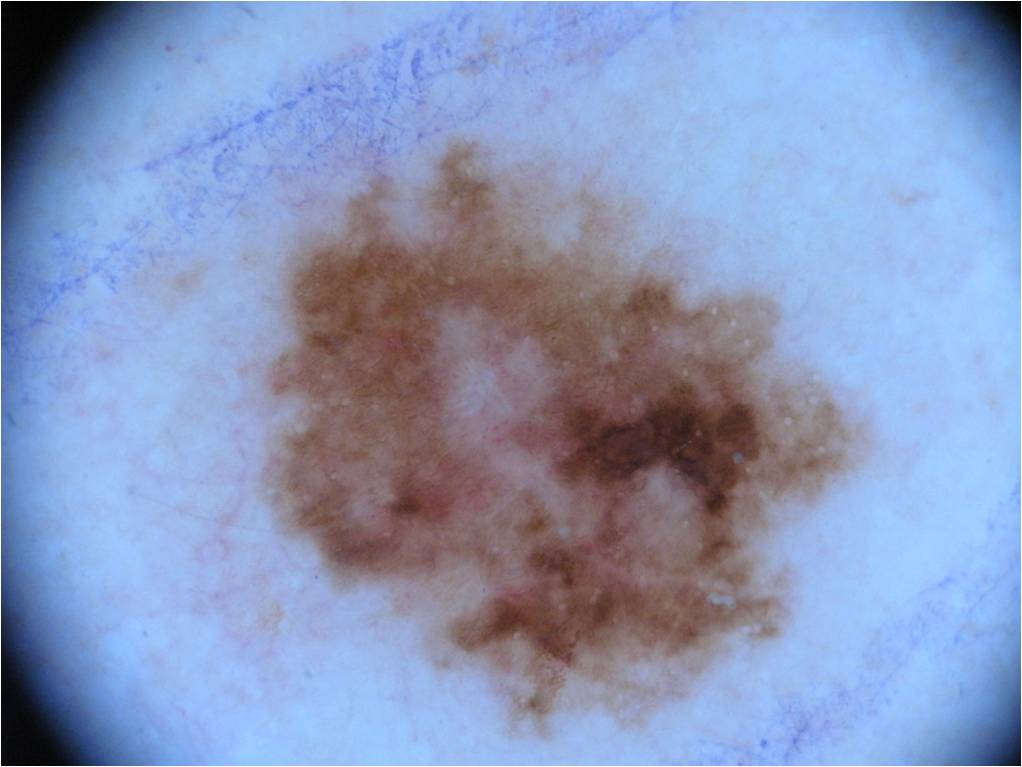

In [49]:
im = Image.open(image_directory+'/ISIC_0000002.jpg')
im.show()

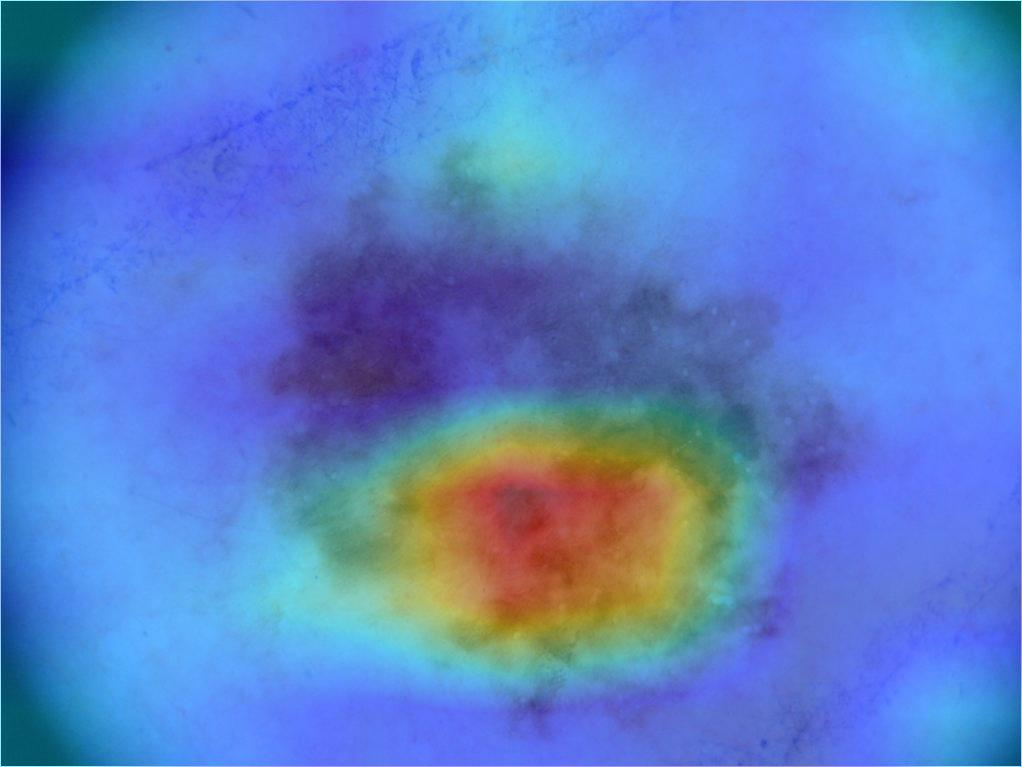

In [50]:
im = Image.open("./data/model_VGG16/xai/ISIC_0000002.jpg")
im.show()

We can see that the majority of the skin lesion are marked red and the prediction seems to work well.

Thank you for reading this notebook. It was part of my job as research assistant at the chair of IT infrastructures for translational medical research at the University of Augsburg and was created in August 2022.


Nadja Bramkamp genannt Beckmann